In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar
from scipy.stats import norm, logistic, norm
from scipy.special import ndtri, expit, erf, erfinv, erfc, erfcinv
import matplotlib.pyplot as plt
import datetime
import math
import warnings

### v_psychofunc
Function definition

In [2]:
def v_psychofunc(m=None, q=None, x=None, r=None):
    # V_PSYCHOFUNC Calculate psychometric functions: trial success probability versus SNR

    # Usage: p=v_psychofunc('',q,x)      % calculate probabilities
    #        b=v_psychofunc('r',q,x)     % generate boolean variables with success prob p
    #        p=v_psychofunc(m,q,x,r)     % Calculate likelihoods for observations r
    #        x=v_psychofunc([m 'i'],q,p) % Calculate inverse

    # Inputs:
    #         m        mode string [may be omitted if not required]
    #                   'n'   do not normalize likelihoods
    #                   'f'   do not squeeze output arrays to remove singleton dimensions
    #                   'i'   calculate inverse function
    #                   'r'   calculate binary random variables with probability p
    #                   ['s'   calculate sweet points for threshold and slope]
    #                   ['d'   calculate partial derivatives with respect to q(1:5)]
    #                   'g'   plot graph
    #                   'G'   plot image
    #                   'c'   include colourbar
    #         q        model parameters. Either a column vector with a single model,
    #                  a matrix with one model per column or a cell array with multiple values for
    #                  some or all of the parameters
    #                   1  probability at threshold [0.5]
    #                   2  threshhold [0 dB]
    #                   3  slope at threshold [0.1 prob/dB ]
    #                   4  miss or lapse probability [0]
    #                   5  guess probability   [0]
    #                   6  psychometric function type [1]
    #                       1 = logistic
    #                       2 = cumulative Gaussian
    #                       3 = Weibull
    #                       [4 = reversed Weibull]
    #                       [5 = Gumbell]
    #                       [6 = reversed Gumbell]
    #         x        vector of SNR values
    #         r        test results (0 or 1) corresponding to x
    #         p        vector of probabilities

    # Outputs:
    #         p        array of probabilities or random variates ('r' option).
    #                  p is a squeezed 7-dimensional array
    #                  whose dimensions correspond to x followed by the 6 model parameter entries.
    #                  if q is a cell array, singleton dimensions are removed unless the 'f' option is given.
    #         x        Inverse function gives SNR, x, as a function of p
    #         b        array of boolean variables

    # first sort out input arguments
    minp = 0.01  # minimum probability to use for inverse function by default
    qq = np.array([0.5, 0, 0.1, 0, 0, 1]).reshape(-1, 1)  # default values for q
    
    if r is None:
        r = np.array([])
        if x is None:
            x = np.array([])
            if q is None:
                q = np.array([])
                if m is None:
                    m = ''
                    nargin = 0
                nargin = 1
            nargin = 2
        nargin = 3
    else:
        nargin=4
        
    if not isinstance(m, str):  # mode argument is optional
        r = x
        x = q
        q = m
        m = ''
        
    sq = q.shape
    ckmod = 0

    if isinstance(q, list):  # Check if q is a list/cell
        nq = np.ones(6, dtype=int)
        qax = [0] + qq.tolist()  # Used for plotting
        for i in range(min(len(q), 6)):
            nq[i] = len(q[i])
            if nq[i] >= 1:
                nr = qq.shape[1]
                qax.append(q[i])
                if i <= 4:  # Do not replicate for multiple models
                    qq = np.tile(qq, (1, nq[i]))
                    qq[i, :] = np.reshape(np.tile(q[i][:], (nr, 1)), (1, nr * nq[i]))
                else:
                    qq[i, :] = np.tile(q[i][0], (1, nr))
        nq = np.maximum(nq, 1)
        nmod = nq[5]
        if nmod > 1:  # List of models to use
            modlist = q[5]
        else:
            modlist = qq[5, 0]  # Default model
    else:
        if len(sq)==1:
            nq=0
        else:
            nq = sq[1]
            
        if nq:
            ql = np.tile(qq, (1, nq))
            ql[:sq[0], :] = q
        else:
            ql = qq
            nq = 1
        modlist = np.unique(ql[5, :])
        nmod = len(modlist)
        ckmod = nmod > 1  # Need to check model list
        qq = ql

    nx = x.shape[0]
    npt = 50  # number of points
    if 'i' in m:  # doing inverse
        if not nx:
            nx = npt
            xlim = np.dot((np.max(qq[4, :]), 1 - np.max(qq[3, :])),np.array([[1 - minp, minp], [minp, 1 - minp]]))
            x = np.linspace(xlim[0], xlim[1], nx)[:, None]
        p = np.zeros((nx, nq))  # space for SNRs
        ia = 0
        for i in range(nmod):  # loop for each model type
            mod = modlist[i]
            if ckmod:
                qq = ql[:, ql[5, :] == mod]
            pscale = 1 - qq[3, :] - qq[4, :]
            pstd = (qq[0, :] - qq[4, :]) / pscale  # prob target compensating for miss and lapse probs
            sstd = qq[2, :] / pscale  # slope compensating for miss and lapse probs
            px = x * (pscale**(-1)) - qq[4, :] / pscale  # adjust for miss and lapse probs
            if mod == 1:
                beta = sstd / (pstd * (1 - pstd))
                px = np.tile(qq[1, :] + np.log((1 - pstd) / pstd) / beta, (nx, 1)) - np.log(px ** (-1) - 1) * np.tile(beta ** (-1), (nx, 1))
            elif mod == 2:  # cumulative Gaussian function
                xtstd = -erfcinv(2 * pstd) * np.sqrt(2)  # x position of target in std measure
                sig = norm.pdf(xtstd)/sstd
                px = qq[1,:]-sig*xtstd-sig*erfcinv(2 * px) * np.sqrt(2)
            elif mod == 3:
                wlog = np.log(1 - pstd)
                kbeta = sstd / ((pstd - 1) * wlog)
                alpha = qq[1, :] - np.log(-wlog) / kbeta
                px = np.tile(alpha, (nx, 1)) + np.log(-np.log(1 - px)) * np.tile(kbeta ** (-1), (nx, 1))
            else:
                raise ValueError('Invalid psychometric model index')
            if ckmod:
                p[:, ql[5, :] == mod] = px
            else:
                ib = ia + np.prod(p.shape) // nmod
                p[ia:ib] = px
                ia = ib
    else:
        if not nx:
            ef = 2  # expansion factor
            nx = npt
            x = np.linspace(np.min(qq[1, :] - ef * (qq[0, :] - qq[4, :]) / qq[2, :]),
                            np.max(qq[1, :] + ef * (1 - qq[0, :] - qq[3, :]) / qq[2, :]), nx)
            x = np.reshape(x, (nx, 1))
        p = np.zeros((nx, nq))  # space for probabilities
        ia = 0
        for i in range(nmod):  # loop for each model type
            mod = modlist[i]
            if ckmod:
                qq = ql[:, ql[5, :] == mod]
            pscale = 1 - qq[3, :] - qq[4, :]  # prob range excluding miss and lapse probs
            pstd = (qq[0, :] - qq[4, :]) / pscale  # prob target compensating for miss and lapse probs
            sstd = qq[2, :] / pscale  # slope compensating for miss and lapse probs
            if mod == 1:  # logistic function
                beta = sstd / (pstd * (1 - pstd))
                px = (1+np.exp(beta * qq[1, :] + np.log((1 - pstd) / pstd) - beta*x))**(-1)
            elif mod == 2:  # cumulative Gaussian function
                xtstd = -erfcinv(2 * pstd) * np.sqrt(2)  # x position of target in std measure
                sigi = sstd / norm.pdf(xtstd)
                px = 0.5 * (1 + erf((sigi*x - qq[1, :] * sigi + xtstd) / np.sqrt(2)))
            elif mod == 3:
                wlog = np.log(1 - pstd)
                kbeta = sstd / ((pstd - 1) * wlog)
                alpha = qq[1, :] - np.log(-wlog) / kbeta
                px = 1 - np.exp(-np.exp(kbeta*x - alpha * kbeta))
            else:
                raise ValueError('Invalid psychometric model index')
            px = np.reshape(qq[4, :], (nq,1)) + np.reshape(pscale, (nq,1)) * px  # adjust for miss and lapse probs
            if ckmod:
                p[:, ql[5, :] == mod] = px
            else:
                ib = ia + np.prod(p.shape) // nmod
                p[ia:ib] = px
                ia = ib
        if np.prod(r.shape):
            mk = r.flatten() == 0
            p[mk, :] = 1 - p[mk, :]  # invert probability for results that are zero
            if nx > 1:
                if 'n' in m:
                    p = np.prod(p, axis=0)
                else:
                    p = np.sum(np.log(p), axis=0)
                    p = np.exp(p - np.max(p))
                    p = p / np.sum(p)  # normalize to equal 1
                nx = 1
                
    pg = p.copy() # save unsqueezed p for plotting

    if 'f' not in m and isinstance(q, list): # remove all singleton dimensions
        szp = np.shape(p)
        szq = szp[szp > 1]
        szq = np.append(szq, np.ones(max(0, 2 - np.size(szq))))
        p = np.reshape(p, szq)

    if 'r' in m and 'i' not in m:
        p = np.random.rand(*np.shape(p)) < p

    if 'g' in m.lower():
        plt.clf()
        szp = [nx, nq]
        czp = sum(i > 1 for i in szp)
        if czp > 0: # check if there is anything to plot
            if isinstance(q, list):
                axlab = ['Input SNR', 'Threshold prob', 'Threshold SNR', 'Threshold slope', 'Lapse prob', 'Guess prob', 'Sigmoid type']
                szs, izs = np.sort(szp)[::-1], np.argsort(szp)[::-1]
                pg = np.transpose(pg, izs)
                qax = [x]
                if 'G' in m or czp > 2: # image
                    ngr = np.prod(szs[2:])
                    ncol = np.ceil(np.sqrt(ngr))
                    nrow = np.ceil(ngr/ncol)
                    npix = np.prod(szs[:2])
                    ia = 0
                    for i in range(ngr):
                        plt.subplot(nrow, ncol, i+1)
                        ib = ia + npix
                        plt.imshow(np.transpose(np.reshape(pg[ia:ib], szs[:2]), (1, 0)))
                        plt.axis('xy')
                        if 'c' in m:
                            plt.colorbar()
                        if nrow*ncol-i < ncol:
                            plt.xlabel(axlab[izs[0]])
                        if (i % ncol) == 0:
                            plt.ylabel(axlab[izs[1]])
                        ia = ib
                else: # graph
                    plt.plot(qax[izs[0]], np.reshape(np.transpose(pg, izs), szs[:2]), '-')
                    plt.xlabel(axlab[izs[0]])
            else:
                if 'G' in m: # image
                    plt.imshow(pg.T)
                    if 'c' in m:
                        plt.colorbar()
                    plt.xlabel('Input SNR (dB)')
                    plt.ylabel('Model Index')
#                     plt.xlim(-1, 1)
#                     plt.ylim(-0.5,1.5)
                else: # graph
                    if nx >= nq:
                        plt.plot(x, pg, '-')
                        plt.xlabel('Input SNR (dB)')
                    else:
                        plt.plot(range(nq), pg.transpose(), '-')
                        plt.xlabel('Model Index')

    return p, x


### v_quadpeak
Function definition

In [3]:
def v_quadpeak(z):
    global wz, a
    sz = np.array(z.shape) # size of input array
    psz = np.prod(sz) # number of elements in input array
    dz = np.size(sz) # number of input dimensions
    mz = np.where(sz > 1)[0] # non-singleton dimension indices
    nm = len(mz) # number of non-singleton dimensions
    vz = sz[mz] # size of squeezed input array
    dx = max(mz) # number of output dimensions
    if nm == 0:
        raise ValueError('Cannot find peak of a scalar')
    
    nc = int((nm + 1) * (nm + 2) / 2)
    
    if np.min(vz) < 3:
        raise ValueError('Need at least 3 points in each non-singleton dimension')
        
    if 'wz' not in globals():
        wz = np.empty([]);

    if wz is None or np.size(wz) != np.size(vz) or not np.all(wz == vz):
        wz = vz.copy()
        a = np.ones((psz, nc))
        ix = np.arange(psz)
        
        for i in range(nm):
            jx = np.floor(ix / sz[mz[i]]).astype(int)
            a[:, i + nc - nm - 1] = 1 + ix - jx * sz[mz[i]]
            ix = jx
            a[:, (-1+(i+1)**2-(i+1)+2)//2:(i+1)*((i+1) + 1)//2] = a[:, nc-nm-1:i+nc-nm] * a[:,i+nc-nm-1].reshape((-1,1))
        a = np.linalg.inv(a.T @ a) @ a.T
    c = a @ z.ravel()
    w = np.zeros((nm + 1, nm + 1))
    i = np.arange(1, nc + 1)
    j = np.floor((np.sqrt(8 * i - 7) - 1) / 2).astype(int)
    w = w.ravel(order='F')
    w[i+j* (2 * nm + 1 - j) // 2 - 1] = c
    w = np.reshape(w, (nm+1, nm+1), order='F')
    w = (w + w.T) / 2
    
    mr = w[:nm, :nm]
    we = w[:nm, nm]
    y = np.flip(-np.linalg.solve(mr, we))
    v = y.T @ we + w[nm, nm]
    x = np.zeros((dx+1, 1))
    x[mz] = np.atleast_2d(y).T

    m = np.zeros((dx + 2, dx + 2))
    mz = np.append(mz,dx+1)
    m[np.ix_(mz,mz)] = w
    ev = np.linalg.eigvals(mr)
    t = float((ev > 0).all()==True) - float((ev < 0).all()==True)

    ze = np.zeros(sz)
    scp = np.cumprod(np.concatenate(([1], sz[:-1])))
    ivec = np.floor(np.tile(np.arange(psz).reshape(-1, 1), (1, dz)) / np.tile(scp, (psz, 1))).astype(int)
    xe = np.concatenate((1 + ivec - np.tile(sz, (psz, 1)) * np.floor(ivec / np.tile(sz, (psz, 1))), np.ones((psz, 1))), axis=1)
    ze = np.sum((xe @ m) * xe, axis=1).reshape(sz)
    
    return v, x, t, m, ze


# Class implementation

In [363]:
class basie_estimator():
#     def __init__(self, nmodels, **kwargs):
#         self.initialise(nmodels, **kwargs)
    def get_next_model(self, **kwargs):
        mq=self.mq
        vq=self.vq
        xn=self.xn
        hn=self.hn
        nr=self.nr
        if 'robust' in kwargs:
            robust = kwargs.get('robust')
        else:
            robust = False
        
        # now select the appropriate model to probe next
        hnmax, ii = np.max(hn), np.argmax(hn)         # choose model with the biggest expected decrease
        xx = xn[ii]
        m, v = mq.copy(), vq.copy()
        if nr[10]:    # if using log-slope
            m[1,:,:] = np.exp(m[1, :, :])  # convert to real slope
            v[1,:] = v[1,:] * m[1, :, 0]  # correct the covariance
            v[2,:] = v[2,:] * m[1, :, 0]**2
        
        if robust==True:
            mqr=self.mqr
            vqr=self.vqr
            return xx, ii+1, m, v, mqr, vqr
        else:
            return xx, ii+1, m, v
        
    def initialise(self, iq, **kwargs):
#             global wq, xq, sq, nr, pr, qr, mq, vq, xn, hn, hfact, xz, res, nres, nresq, xmm, mq0, pq0, wfl, sqmin, LOG, mqr, vqr, nresr, xlim
        # ---------- check kwargs ---------- #
        if 'modelp' not in kwargs:
            warnings.warn('No model parameters found. Using defaults')
            x = None
        else:
            x = kwargs.get('modelp')
        
        if 'basiep' not in kwargs:
            warnings.warn('No basie parameters found. Using defaults')
            r = None
        else:
            r = kwargs.get('basiep')
        
        if 'availsnr' not in kwargs:
            warnings.warn('No available snr found. Using defaults')
            xp = None
        else:
            xp = kwargs.get('availsnr')
            
        if 'logfile' in kwargs:
            LOG = kwargs.get('logfile')
            with open(LOG, 'a') as f:
                f.write("******************************\n")
                f.write("psycest Initialization: {}\n".format(str(datetime.datetime.now())))
                f.write("******************************\n")
        else:
            LOG = None
        
        # initialise number of models
        ni = iq                 # number of models
        nres = 0                 # total number of probe-results so far
        nresq = np.atleast_2d(np.zeros((1,ni)))    # number of probe-results for each model
        res = np.atleast_2d(np.zeros(7))        # array for saving results [expands as needed]
        
        
        # initialise model specific parameters
        pr = np.tile([0.5, 0.04, 0.1, -20, 20, 0, 0.5], (ni, 1)).T         # default parameters
        if x is not None:
            if isinstance(x, list):
                x=np.tile(x, (1, 1)).T
            if 7 not in np.shape(x):
                raise ValueError('Requires 7 modelp')
            if len(np.shape(x))==1:
                x = np.atleast_2d(x)
            if np.shape(x)[1]==7 and np.shape(x)[0]!=7:
                x = x.T
            if x.shape[1] > 1:
                if x.shape[1] > ni:
                    raise ValueError("initialization parameter argument has too many columns")
                pr[:x.shape[0], :x.shape[1]] = x
            else:
                pr[:x.shape[0], :] = np.tile(x, (1, ni))
        
        # initialise parameters common to all models
        nr = np.array([40, 21, 30, 1, 0.2, 0.02, 4, 1.3, 2, 1, 1, 1, 0.0001, 2, 10, 0.5, 0.1, 1, 0.01, 0.5])                      # default parameter values
        nrf = np.array(['nx', 'ns', 'nh', 'cs', 'dh', 'sl', 'kp', 'hg', 'cf', 'pm', 'lg', 'pp', 'pf', 'ts', 'dp', 'it', 'at', 'la', 'op', 'rx']).T     # parameter field names
        numnr = len(nr)
        if r is not None: # replace defaults with any parameter values specified in the call
            if isinstance(r, dict):
                for k, v in r.items():
                    mk = [x == k for x in nrf]
                    if any(mk):
                        nr[mk] = v
            else:
                nr[:min(numnr, len(r))] = r[:min(numnr, len(r))] # if parameters are specified as a vector, copy them across
            nr[:3] = np.round(nr[:3])             # first three parameters must be integers
        pr[5, :] = np.maximum(pr[5, :], nr[5])             # low limit of slope in prob/dB
        nxq = nr[0]
        nsq = nr[1]
        nsxq = nxq * nsq
        xq = np.linspace(pr[3], pr[4], int(nxq))

        if nr[10]:  # if log slope
            sqmin = np.log(nr[5])  # low limit for axis
#             sq = np.array((np.arange(1-nsq, 1,1)*(np.log(pr[6, :]) - np.log(np.maximum(pr[5, :], nr[5])))/(nsq-1)) + np.log(pr[6, :]),ndmin=2).T
            sq = np.outer((np.arange(1-nsq, 1,1)),(np.log(pr[6, :]) 
                                                   - np.log(np.maximum(pr[5, :], nr[5]))))/(nsq-1) + np.tile(np.log(pr[6, :]),(int(nsq),1))
        else:
            sqmin = nr[5].copy()  # low limit for axis
            sq = np.array((np.arange(1-nsq, 1,1)*(pr[6, :] - np.maximum(pr[5, :], nr[5]))/(nsq-1)) + pr[6, :],ndmin=2).T
            
        mq0 = np.vstack((np.mean(xq, axis=0), np.mean(sq, axis=0)))  # find mean of prior
        pq0 = -2 * nr[11]**2 * np.power(np.vstack((xq[-1, :] - xq[0, :], sq[-1, :] - sq[0, :])), -2)  # scale factor for prior distribution
        wq = (np.tile((pq0[1, 0] * np.power((sq[:, 0] - mq0[1, 0]), 2)), (int(nxq),1)) + np.tile(pq0[0, 0] * np.power((xq[:, 0] - mq0[0, 0]), 2),(int(nsq),1)).T) # log probs of prior (same for all models)

        wfl = np.log(nr[12] / nsxq)  # floor relative to peak of wq array
        wq = np.tile(wq.ravel(), (ni,1)).T  # initialize to +-q.pp std deviations of gaussian prior
        qr = np.zeros((5, ni))
        
        qr[0, :] = 1 - pr[1, :] - pr[2, :]  # prob range covered by cumulative gaussian
        
        
        if np.any(qr[0, :] <= 0):
            i = np.argmin(qr[0, :])
            raise ValueError(f"Model {i}: guess prob ({pr[2, i]:.2f}) + miss prob ({pr[1, i]:.2f}) is >=1")
        qr[1, :] = (pr[0, :] - pr[2, :])/qr[0, :]  # cumulative gaussian probability at threshold
        if np.any(np.abs(qr[1, :] - 0.5) >= 0.5):
            i = np.argmax(np.abs(qr[1, :] - 0.5))
            raise ValueError(f"Model {i}: target SRT threshold ({pr[0, i]:.2f}) must lie in the range guess prob ({pr[2, i]:.2f}) to (1-miss prob) ({1-pr[1, :]:.2f})")

        if nr[9] == 1:  # logistic model
            qr[2,:] = np.log(qr[1,:]/(1-qr[1,:]))
            qr[3,:] = qr[0,:]*qr[1,:]*(1-qr[1,:])
        elif nr[9] == 2:  # cumulative gaussian model
            qr[2,:]= -erfcinv(2 * qr[1,:]) * np.sqrt(2)
            qr[3,:] = qr[0,:]*norm.pdf(qr[2,:])
        else:
            raise ValueError('Unrecognised psychometric model selection')

        if nr[9] < 1 or nr[9] > 2:
            raise ValueError('Unrecognised cost function option')
        mq = np.tile(mq0.T, (3, 1, 1)).T  # initial means, joint mode and marginal mode all are equal
        vq = np.vstack((np.var(xq, axis=0, ddof=0), np.zeros((1, ni)), np.var(sq, axis=0, ddof=0)))  # initial variances (actually ignores prior probs)
        mqr = mq.copy()  # robust means and modes
        vqr = vq.copy()  # robust variances
        nresr = 0  # robust calculation time
        xlim = np.vstack((-np.inf * np.ones(ni), np.inf * np.ones(ni)))  # SNR limits for outliers
        hn = np.inf * np.ones(ni)  # very high initial cost function
        hfact = nr[7] ** (1 / ni)  # growth factor to ensure that no model is neglected for too long
        xn = mq0[0, :].copy()  # start at mean value
        xmm = np.vstack((xn, xn))  # min/max of probe values for each model
        
        # initialise available snrs
        if xp is not None and len(xp) > 0:
            if xp.ndim>1:
                xz = np.atleast_2d(xp)
            else:
                xz = np.tile(np.expand_dims(xp, axis=0), (ni, 1)).tolist()  # else replicate for each model
            for i in range(ni):
                j = np.argmin(np.abs(np.array(xz[i]) - mq0[0, i]))  # select the closest available probe to the mean
                xn[i] = xz[i][j]
        else:
            xz = [None] * ni  # make empty list
            
        self.wq=wq
        self.xq=xq
        self.sq=sq
        self.nr=nr
        self.pr=pr
        self.qr=qr
        self.mq=mq
        self.vq=vq
        self.xn=xn
        self.hn=hn
        self.hfact=hfact
        self.xz=xz
        self.res=res
        self.nres=nres
        self.nresq=nresq
        self.xmm=xmm
        self.mq0=mq0
        self.pq0=pq0
        self.wfl=wfl
        self.sqmin=sqmin
        self.LOG=LOG
        self.mqr=mqr
        self.vqr=vqr
        self.nresr=nresr
        self.xlim=xlim
        
        return self.get_next_model()
        
    def update(self, iq, **kwargs):
        wq=self.wq
        xq=self.xq
        sq=self.sq
        nr=self.nr
        pr=self.pr
        qr=self.qr
        mq=self.mq
        vq=self.vq
        xn=self.xn
        hn=self.hn
        hfact=self.hfact
        xz=self.xz
        res=self.res
        nres=self.nres
        nresq=self.nresq
        xmm=self.xmm
        mq0=self.mq0
        pq0=self.pq0
        wfl=self.wfl
        sqmin=self.sqmin
        LOG=self.LOG
        mqr=self.mqr
        vqr=self.vqr
        nresr=self.nresr
        xlim=self.xlim
        # iq>0 means update or plot model iq
        # first check the plotting options
        if 'plotopts' in kwargs:
            po = kwargs.get('plotopts')
        else:
            po = ''

        if 'probesnr' in kwargs:
            x = kwargs.get('probesnr')
        else:
            x = None

        if 'response' in kwargs:
            r = kwargs.get('response')
            if isinstance(r, bool):
                r=np.array([[(r)]])
            elif isinstance(r, int) or isinstance(r, float):
                r=np.array([[(r==1)]])
        else:
            r = None

        if 'robust' in kwargs:
            robust = kwargs.get('robust')
        else:
            robust = False

        # now get parameters of current model (iq)
        nxq = nr[0] # number of snr values
        nsq = nr[1] # number of slope values
        nxh = nr[2] # number of probe-snr values
        nsxq = nxq*nsq # size of log pdf array

        thresh = pr[0,iq-1].copy() # target probability at threshold
        guess = pr[2,iq-1].copy() # quess rate (1/choices)
        pscale = qr[0,iq-1].copy() # prob range left after substracting miss and guess probs
        xtstd = qr[2,iq-1].copy() # x position of target in std measure

        xqi = xq[:,iq-1].copy() # SRT values of the pdf array
        sqi = sq[:,iq-1].copy() # slope (or log slope) values in PDF
        wqi = wq[:,iq-1].copy() # log pdf array
        mqi = mq[:,iq-1,0].copy() # [xe;se] means
        vqi = vq[:,iq-1].copy() # [xv; sxv; sv] covariance matrix

        # rescale pdfs if necessary
        ssd = np.sqrt(vqi[2])           # std deviation of slope
        xsd = np.sqrt(vqi[0])           # std deviation of SRT
        # determine range of new grid
        xqrange = xqi[-1] - xqi[0]      # range of old SRT grid
        sqrange = sqi[-1] - sqi[0]      # range of old slope grid

        if nresq[0,iq-1] < 2:               # keep old limits if nresq(iq) < 2
            xq2lim = [xqi[0], xqi[-1]]
            sq2lim = [sqi[0], sqi[-1]]
        else:
            # CHECK HERE
            xqsemirange = max(nr[6] * xsd, 0.5 * nr[19] * xqrange)
            xq2lim = [mqi[0] - xqsemirange, mqi[0] + xqsemirange]
            sqsemirange = max(nr[6] * ssd, 0.5 * nr[19] * sqrange)
            sq2lim = [max(sqmin, mqi[1] - sqsemirange), mqi[1] + sqsemirange]

            if abs(xq2lim[0] - xqi[0]) < nr[16] * xqrange:
                xq2lim[0] = xqi[0]
            if abs(xq2lim[1] - xqi[-1]) < nr[16] * xqrange:
                xq2lim[1] = xqi[-1]

            if abs(sq2lim[0] - sqi[0]) < nr[16] * sqrange:
                sq2lim[0] = sqi[0]
            if abs(sq2lim[1] - sqi[-1]) < nr[16] * sqrange:
                sq2lim[1] = sqi[-1]

        xq2 = np.linspace(xq2lim[0], xq2lim[1], int(nxq)).reshape(-1, 1) # new x axis values
        sq2 = np.linspace(sq2lim[0], sq2lim[1], int(nsq)).reshape(-1, 1) # new s axis values
        wqup = 2 # update flag

        if xq2[0] < xqi[0] or xq2[-1] > xqi[-1] or sq2[0] < sqi[0] or sq2[-1] > sqi[-1]:
#             if extrapolating, recalculate log-pdfs from saved data
            if LOG:
                print(f'N={iq}:{int(nresq[0,iq-1])}, extrapolate: x({xqi[0]:.2f},{xqi[-1]:.2f})->({xq2[0]},{xq2[-1]}) and s({sqi[0]:.2f},{sqi[-1]:.2f})->({sq2[0]},{sq2[-1]})')

            wq2 = (np.tile(pq0[1,iq-1]*(sq2-mq0[1,iq-1])**2, (1,int(nxq))).T + np.tile(pq0[0,iq-1]*(xq2-mq0[0,iq-1])**2, (1,int(nsq)))).T # log probs of prior for model iq
            ires = np.where(res[:nres,0] == iq-1)[0] # find the results for this model
            sqis = np.exp(sq2)/qr[3,iq-1] if nr[10] else sq2/qr[3,iq-1] # inverse std dev of gaussian (proportional to slope)
            for i in range(len(ires)):
                j = ires[i]
                r0 = res[j,2] == 0
                if nr[9] == 1:
                    wq2 = wq2 + np.log(r0 + (1 - 2*r0) * (guess + pscale * (1 + np.exp(np.multiply(sqis, xq2.T) - xtstd - np.multiply(sqis, res[j,1])))**(-1))) # P(l | r,x)
                elif nr[9] == 2:
                    wq2 = wq2 + np.log(r0 + (1 - 2*r0) * (guess + pscale * norm.cdf(np.multiply(sqis, res[j,1]) - np.multiply(sqis, xq2.T) + xtstd))) # P(l | r,x)

        else:
            # Turn into a normalized, clipped matrix for easy interpolation
            wq2 = np.maximum(np.reshape(wqi, (int(nsq), int(nxq))) - np.max(wqi), wfl)
            # Use quadratic interpolation in SRT axis
            if ((xq2[-1] - xq2[0]) / (xqrange)) > nr[15]:
                # If range has shrunk by < nr(16), leave the SRT axis unchanged
                xq2 = xqi.copy()  # Copy the old SRT axis
                wqup = 1  # Update flag
            else:
                # Do quadratic interpolation
                if LOG:
                    print(f'N={iq}:{nresq[0, iq-1]}, interpolate x: x({xqi[0]},{xqi[-1]})->({xq2[0]},{xq2[-1]})')
                xqf = (xq2 - xqi[0]) / (xqi[1] - xqi[0])
                xqj = np.ceil(xqf).astype(int)
                xqf = xqj - xqf
                xqg = 1 - xqf
                xqh = 0.25 * xqf * xqg  # Quadratic coefficient

                mask1 = (xqj <= 0) | (xqj > nxq)
                mask2 = (xqj < 0) | (xqj >= nxq)
                mask3 = (xqj < 1) | (xqj >= nxq - 1)
                xqf[mask1] = 0
                xqg[mask2] = 0
                xqh[mask3] = 0

                temp1 = wq2[:, tuple((np.minimum(np.maximum(xqj, 1), nxq) - 1).astype(int))] * (xqf + xqh)
                temp2 = wq2[:, tuple((np.minimum(np.maximum(xqj + 1, 1), nxq) - 1).astype(int))] * (xqg + xqh)
                temp3 = (wq2[:, tuple((np.minimum(np.maximum(xqj - 1, 1), nxq) - 1).astype(int))] + 
                         wq2[:, tuple((np.minimum(np.maximum(xqj + 2, 1), nxq) - 1).astype(int))]) * xqh

                wq2 = temp1 + temp2 - temp3

            # Use quadratic interpolation in slope axis
            if ((sq2[-1] - sq2[0]) / (sqrange)) > nr[15]:
                # If range has shrunk by < nr(16), leave the slope axis unchanged
                sq2 = sqi.copy()  # Copy the old slope axis
                wqup -= 1  # Update flag
            else:
                # Do quadratic interpolation
                if LOG:
                    print(f'N={int(iq)}:{int(nresq[iq])}, interpolate s: s({sqi[0]:.2g},{sqi[-1]:.2g})->({sq2[0]:.2g},{sq2[-1]:.2g})')

                sqf = (sq2 - sqi[0]) / (sqi[1] - sqi[0])
                sqj = np.ceil(sqf).astype(int)
                sqf = sqj - sqf
                sqg = 1 - sqf
                sqh = 0.25 * sqf * sqg # Quadratic coefficient
                
                mask1 = (sqj <= 0) | (sqj > nsq)
                mask2 = (sqj < 0) | (sqj >= nsq)
                mask3 = (sqj < 1) | (sqj >= nsq - 1)
                sqf[mask1] = 0
                sqg[mask2] = 0
                sqh[mask3] = 0

                temp1 = wq2[:, tuple((np.minimum(np.maximum(sqj, 1), nsq) - 1).astype(int))] * (sqf + sqh)
                temp2 = wq2[:, tuple((np.minimum(np.maximum(sqj + 1, 1), nsq) - 1).astype(int))] * (sqg + sqh)
                temp3 = (wq2[:, tuple((np.minimum(np.maximum(sqj - 1, 1), nsq) - 1).astype(int))] + 
                         wq2[:, tuple((np.minimum(np.maximum(sqj + 2, 1), nsq) - 1).astype(int))]) * sqh
                wq2 = temp1 + temp2 - temp3
                
#                 sqf[(sqj <= 0) | (sqj > nsq)] = 0
#                 sqg[(sqj < 0) | (sqj >= nsq)] = 0
#                 sqh[(sqj < 1) | (sqj >= nsq-1)] = 0
#                 wq2 = wq2[min(np.maximum(sqj, 1), nsq)-1, :]*np.tile(sqf+sqh, (nxq,1)).T+wq2[min(np.maximum(sqj+1, 1), nsq)-1, :] * np.tile(sqg+sqh, (nxq,1)).T -(wq2[min(np.maximum(sqj-1, 1), nsq)-1, :] + wq2[min(np.maximum(sqj+2, 1), nsq)-1, :]) * np.tile(sqh, (nxq,1)).T

        if wqup > 0:
            wq2 = np.maximum(wq2 - np.max(wq2), wfl) # turn back into a normalized, clipped vector
            wq2 = wq2.ravel(order="F")
            sqi = np.atleast_2d(sq2.copy()) # update slope (or log slope) values in PDF
            xqi = xq2.copy() # update SRT values of the pdf array
            wqi = wq2.copy() # log pdf array
            sq[:, iq-1] = sqi[:,0] # save new s axis (log slope or slope)
            xq[:, iq-1] = xqi[:,0] # save new x axis (SRT)
            wq[:, iq-1] = wqi.copy() # save log-pdf
        if nr[10]:
            sqis = np.exp(sqi) / qr[3, iq-1] # inverse std dev of gaussian (proportional to slope)
        else:
            sqis = sqi / qr[3, iq-1] # inverse std dev of gaussian (proportional to slope)

        if r is not None: # CHECK THAT THIS ACHIEVES THE SAME RESULT
            if nres >= res.shape[0]:  # ensure there is space for a new result
                res = np.vstack((res, np.zeros((nres, 7)))) #double the size of the results array
            nres += 1  # increment the total number of results
            nresq[0,iq-1] += 1  # increment the number of results for this model
            res[nres - 1, :3] = np.array([float(iq-1), x, float(r==True)])  # save the latest result
            xmm[:, iq-1] = [min(x, xmm[0, iq-1]), max(x, xmm[1, iq-1])]  # update min/max probe values

            # warning: xmm is not exactly like matlab because of numeric precision
            hn *= hfact  # increase v_entropy gains to ensure all models get a chance
            r0 = r == 0
            if nr[9] == 1:
                sqis = sqis.ravel()
                xqi = xqi.ravel()
                wqi = wqi + np.log(r0 + (1 - 2 * r0) *
                                   (guess + pscale * 
                                    (((1 + np.exp((np.outer(sqis, xqi) - xtstd)-np.tile((x*sqis),(int(nxq),1)).T)).ravel(order='F'))**(-1)))) # P(l | r,x)
            elif nr[9] == 2:
                sqis = sqis.ravel()
                xqi = xqi.ravel()
                wqi = wqi + np.log(r0 + (1 - 2 * r0) * (guess + pscale * norm.cdf(np.outer(sqis, x) - np.reshape(sqis * xqi - xtstd, (nsxq, 1)))))  # P(l | r,x)
            else:
                raise ValueError('Unrecognised psychometric model selection')
            wq[:, iq-1] = wqi  # save updated probabilities

        ewqi = np.exp(wqi - np.max(wqi))             # unnormalized probability vector
        ewqi = ewqi / np.sum(ewqi)
        wqsx = np.reshape(ewqi, (int(nxq), int(nsq))).T        # normalized probabilities
        xqi = xqi.ravel()
        sqi = sqi.ravel()

        px = np.sum(wqsx, axis=0)                             # p(x0)
        ps = np.sum(wqsx, axis=1)                             # p(s0)
        xe = np.dot(px, xqi)                                  # E(x0)
        se = np.dot(ps, sqi)                                  # E(s0)

        pxpk, xm = np.max(px), np.argmax(px)
        if xm > 0 and xm < nxq-1:                           # use quadratic interpolation in log prob if possible
            log_px = np.log(px[xm-1:xm+2])
            xm2 = v_quadpeak(log_px)
            xm2 = xm2[1]
            xm = xm + xm2 - 1
        xm = (2 - xm) * xqi[0] + (xm - 1) * xqi[1]             # marginal mode(x0)

        pspk, sm = max((ps[i], i) for i in range(int(nsq)))
        if sm > 0 and sm < nsq-1:                           # use quadratic interpolation in log prob if possible
            log_ps = np.log(ps[sm-1:sm+2])
            sm2 = v_quadpeak(log_ps)
            sm2 = sm2[1]
            sm = sm + sm2 - 1
        sm = (2 - sm) * sqi[0] + (sm - 1) * sqi[1]             # marginal mode(s0)

        wqpk, j = max((ewqi[0,i], i) for i in range(int(nsq*nxq)))
        i = (j-1) // nsq
        j = j - nsq * (i)

        if i > 0 and i < nxq-1 and j > 0 and j < nsq-1:             # use quadratic interpolation in log prob if possible
            wqi_3x3 = wqi[0,((np.tile(np.arange(j-1,j+2).reshape((-1,1)), (1,3))+nsq*np.tile(np.arange(i-1,i+2),(3,1))).ravel(order='F')).astype(int)].reshape((-1,np.arange(i-1,i+2).size), order='F')
            ji = v_quadpeak(wqi_3x3)
            ji = ji[1]
            i = i + ji[1] - 1
            j = j + ji[0] - 1
        xj = (2 - i) * xqi[0] + (i - 1) * xqi[1]  # joint mode  x
        sj = (2 - j) * sqi[0] + (j - 1) * sqi[1]  # joint mode: s

        xv = np.dot(px, (xqi ** 2)) - xe ** 2  # Var(x0)
        sv = np.dot(ps.T, sqi ** 2) - se ** 2  # Var(s0)
        xqi = xqi.ravel()
        sqi = sqi.ravel()
        sxv = np.dot(ewqi, (np.tile(sqi - se, int(nxq)) *
                              np.tile(xqi.T - xe, (int(nsq),1)).ravel(order="F")))  # Cov(s0*x0)
        mq[:, iq-1, 0] = np.array([xe, se])  # save means
        mq[:, iq-1, 1] = np.array([xj.item(), sj.item()])  # save joint mode
        mq[:, iq-1, 2] = np.array([xm.item(), sm.item()])  # save marginal modes

        vq[:, iq-1] = np.array([xv, sxv.item(), sv])  # save covariance matrix
        xh = np.dot(px, np.log(px).T) * (xqi[0] - xqi[1])  # differential v_entropy h(x0)
        sh = np.dot(ps.T, np.log(ps)) * (sqi[0] - sqi[1])  # differential v_entropy h(s0)

        # if not plotting
        if po == '':
            if nr[8] == 1:  # cost function: 1=variance, 2=v_entropy
                res[nres-1, 3:7] = [xe, se, xv, sv]  # save info for plotting history
            elif nr[8] == 2:
                res[nres-1, 3:7] = [xe, se, xh, sh]  # find the minimum of cost function

        ################################################################################
        ##### Calculate ROBUST ESTIMATES ###############################################
        ################################################################################
        if robust==True:
            if nr[18]==0:
                mr=mq.copy()
                vr=vq.copy()
            elif nresr==nres:
                mr=mqr.copy()
                vr=vqr.copy()
            else:
#                 print(res) 
                for jq in range(nresq.size):
                    if any(res[nresr:nres+1,0]==jq):
                        guessj=pr[2,jq]
                        pscalej=qr[0,jq]
                        xtstdj=qr[2,jq]
                        xqj=xq[:,jq]
                        sqj=sq[:,jq]
                        
                        xej=mq[0,jq,0]
                        sej=mq[1,jq,0]
                        resj=res[res[:,0]==jq,:]
                        if nr[10]==1:
                            sqisj=np.exp(sej)/qr[3,jq]
                        else:
                            sqisj=sej/qr[3,jq]
                        
                        if nr[9]==1:
                            xlim[1,jq]=xej-(xtstdj+np.log(nr[18]/(pscalej-nr[18])))/sqisj
                        elif nr[9]==2:
                            xlim[1,jq]=xej-(-erfcinv(2*((pscalej-nr[18])/pscalej))*np.sqrt(2)-xtstdj)/sqisj
                            
                        mou=np.logical_and(resj[:,1]>=xlim[1,jq] ,resj[:,2]==0)
                        if nr[19]>guessj:
                            if nr[9]==1:
                                xlim[0,jq]=xej-(xtstdj+np.log(pscalej/(nr[18]-guessj)-1))/sqisj
                            elif nr[9]==2:
                                xlim[0,jq]=xej+(-erfcinv(2*((pscale-nr[18])/pscalej))*np.sqrt(2)-xtstdj)/sqisj
                            mou=np.logical_or(mou, np.logical_and(resj[:,1]<=xlim[0,jq], resj[:,2]==1))
                        if any(mou):
                            if nr[10]==1:
                                sqisj=np.exp(sqj)/qr[3,jq]
                            else:
                                sqisj=sqj/qr[3,jq]
                                
                            
                            wqj=np.tile(pqo[1,jq]*(sqj-mq0[1,jq])**2,(int(nxq),1))+np.tile(pqo[0,jq]*(xqj-mq0[0,jq])**2,(int(nsq),1))

                            if nr[9]==1:
                                sqisj = sqisj.ravel()
                                xqj=xqj.ravel()
                                for j in np.where(mou==0):
                                    r0=(resj[j,2]==0)
                                    wqj=wqj+np.log(r0+(1-2*r0)*
                                                   (guessj+pscalej*
                                                    (((1+np.exp((np.outer(sqisj,xqj)-xtstdj)-np.tile(resj[j,1]*sqisj,(int(nxq),1)).T)).ravel(order='F'))**(-1))))
                            elif nr[9]==2:
                                for j in np.where(mou==0):
                                    r0=(resj[j,2]==0)
                                    wqj=wqj+np.log(r0+(1-2*r0)*(guessj+pscalej*norm.cdf(np.tile(sqisj,(int(nxq),1))
                                                                                       *resj[j,1]-
                                                                                       sqisj*xqj.T+xtstdj)))
                            wqj=wqj[:].copy()
                            ewqj=np.exp(wqj-np.max(wqj))
                            ewqj=ewqj/np.sum(ewqj)
                            wqsxr=np.reshape(ewqj, (int(nsq),int(nxq)), order="F")
                            pxr=np.sum(wqsxr, axis=0)
                            psr=np.sum(wqsxr, axis=1)
                            xer=pxr*xqj
                            ser=psr.T*sqj
                            [pxpk,xmr]=np.max(pxr), np.argmax(pxr)
                            if xmr>0 and xnr<nxq-1:
                                log_px = np.log(px[xmr-1:xmr+2])
                                xm2 = v_quadpeak(log_px)
                                xm2 = xm2[1]
                                xmr = xmr + xm2 - 1
                            xmr = (2 - xmr) * xqj[0] + (xmr - 1) * xqj[1]
                            [pspk, smr]=np.max(psr), np.argmax(psr)
                            if smr>0 and snr<nsq-1:
                                log_px = np.log(px[smr-1:smr+2])
                                sm2 = v_quadpeak(log_px)
                                sm2 = sm2[1]
                                smr = smr + sm2 - 1
                            smr = (2 - smr) * sqj[0] + (smr - 1) * sqj[1]
                            
                            wqpk, j = max((ewqj[0,i], i) for i in range(int(nsq*nxq)))
                            i = (j-1) // nsq
                            j = j - nsq * (i)

                            if i > 0 and i < nxq-1 and j > 0 and j < nsq-1:             # use quadratic interpolation in log prob if possible
                                wqi_3x3 = wqj[0,((np.tile(np.arange(j-1,j+2).reshape((-1,1)), (1,3))+nsq*np.tile(np.arange(i-1,i+2),(3,1))).ravel(order='F')).astype(int)].reshape((-1,np.arange(i-1,i+2).size), order='F')
                                ji = v_quadpeak(wqi_3x3)
                                ji = ji[1]
                                i = i + ji[1] - 1
                                j = j + ji[0] - 1
                            xjr = (2 - i) * xqj[0] + (i - 1) * xqj[1]  # joint mode  x
                            sjr = (2 - j) * sqj[0] + (j - 1) * sqj[1]  # joint mode: s

                            xvr = np.dot(pxr, (xqj ** 2)) - xer ** 2  # Var(x0)
                            sv = np.dot(psr.T, sqj ** 2) - ser ** 2  # Var(s0)
                            xqj = xqj.ravel()
                            sqj = sqj.ravel()
                            sxvr = np.dot(ewqj, (np.tile(sqj - ser, int(nxq)) *
                                                  np.tile(xqj.T - xer, (int(nsq),1)).ravel(order="F")))  # Cov(s0*x0)
                            mqr[:, jq, 0] = np.array([xer, ser])  # save means
                            mqr[:, jq, 1] = np.array([xjr.item(), sjr.ritem()])  # save joint mode
                            mqr[:, jq, 2] = np.array([xmr.item(), smr.item()])  # save marginal modes

                            vqr[:, jq] = np.array([xvr, sxvr.item(), svr])  # save covariance matrix
                        else:
                            mqr[:,jq,:]=mq[:,jq,:].copy()
                            vqr[:,jq]=vq[:,jq].copy()
                            
        if len(xz[iq-1])==0:
            print('Have not implement free SNR estimation yet, matlab lines 678-709')
        else:
            xzi = xz[iq-1]  # xzi is the list of available probe SNRs
            if len(xzi) <= nxh:  # use all available probe SNRs if there are not too many
                xt = xzi
            else:
                ixt = np.argmin(np.abs(xzi - xe))  # find the closest one to xe ** not necessarily optimum ***
                ixt = max(0, min(len(xzi) - nxh, ixt - int((1 + nxh) / 2)))  # arrange symmetrically around xt
                xt = xzi[int(ixt):int(min(ixt + nxh, len(xzi)))]

        nxhp = len(xt)  # xt are the potential probe SNRs
        # Now find the probe value that minimizes the expected value of the cost function
        # In the following: l = parameters of psychometric function, x = the probe SNR and r = the probe result
        if nr[9] == 1:
            prt = guess + pscale*((1 + np.exp(np.tile((np.outer(sqis, xqi) - xtstd).ravel(order="F"),(int(nxhp),1))-
                                              np.outer(np.tile(sqis,int(nxq)),(xt)).T))**(-1)).T  # P(r=1 | l,x)
        elif nr[9] == 2:
            prt = guess + pscale*norm.cdf(np.tile(sqis, (nxq, 1)) @ xt - np.tile(np.reshape(sqis @ xqi - xtstd, (nsxq, 1)), (1, nxhp)))  # P(r=1 | l,x)

        wqt = np.tile(ewqi, (int(nxhp),1)).T
        hminr = np.zeros((2, 1))  # space for minimum expected cost function for each r0
        hminj = np.zeros((nxhp, 1))  # space for minimum expected cost function for each x0

        if nr[17]:  # if doing look 2-ahead
            pl1 = prt * wqt  # posterior prob given success = p(l | x0,r0=1) unnormalized
            pl0 = wqt - pl1  # posterior prob given failure = p(l | x0,r0=0) unnormalized
            pr0 = np.sum(pl1, axis=0)  # p(r0=1 | x0)=Sum{P(r0=1 | l,x0)*P(l)} [note each column of wqt is normalized] (row vector)

#             print((pl0 / np.tile(1 - pr0, (int(nsxq), 1)))[0,:])
            plxr = np.reshape(np.concatenate((pl0 / np.tile(1 - pr0, (int(nsxq), 1)), 
                                              pl1 / np.tile(pr0, (int(nsxq), 1))), axis=1), (int(nsxq), int(nxhp), 2), order="F")  # posterior prob p(l | x0,r0) column-normalized
            nx0 = nxhp  # outer loop for each x0
            nr0 = 2  # inner loop for each r0

        else:  # if only doing look 1-ahead
            nx0 = 0  # only execute outer loop once
            nr0 = 0  # only execute inner loop once
            pr0 = -1  # dummy value (used at end of outer loop)

        hx2 = np.zeros((nx0, nxhp, nr0)) # space for square array of expected cost functions (for possible plotting only)

        for j in range(nx0): # loop for each possible probe SNR, x0, (or only once is look-1-ahead)
            for jr in range(nr0): # loop for each possible test result, r0=jr-1 (or only once is look-1-ahead)
                if nr[17]: # if doing look 2-ahead
                    wqt = np.tile(plxr[:, j, jr], (nxhp,1)).T # posterior prob p(l | x0=xt(j),r0=jr-1) column-normalized

                pl1 = prt * wqt # posterior prob given success = p(l | x,r=1) unnormalized
                pl0 = wqt - pl1 # posterior prob given failure = p(l | x,r=0) unnormalized
                prh = np.atleast_2d(np.sum(pl1, axis=0)) # p(r | x)=Sum{P(r | l,x)*P(l)} [note each column of wqtjr is normalized] (row vector)

                pl1 = pl1 / np.tile(prh, (int(nsxq), 1)) # posterior prob given success = p(l | x,r=1) normalized
                pl0 = pl0 / np.tile(1 - prh, (int(nsxq), 1)) # posterior prob given failure = p(l | x,r=0) normalized
                px1 = np.sum(np.reshape(pl1, (int(nsq), int(nxq), -1), order="F"), axis=0) # p(x0 | x,r=1)
                px0 = np.sum(np.reshape(pl0, (int(nsq), int(nxq), -1), order="F"), axis=0) # p(x0 | x,r=0)
                ps1 = np.sum(np.reshape(pl1, (int(nsq), int(nxq), -1), order="F"), axis=1) # p(s0 | x,r=1)
                ps0 = np.sum(np.reshape(pl0, (int(nsq), int(nxq), -1), order="F"), axis=1) # p(s0 | x,r=0)
                xqi = np.atleast_2d(xqi)
                sqi = np.atleast_2d(sqi)

                xet1 = np.dot(xqi, px1) # E(x0 | x,r=1)
                xvt1 = np.dot(xqi**2, px1) - xet1**2 # Var(x0 | x,r=1)
                xet0 = np.dot(xqi, px0) # E(x0 | x,r=0)
                xvt0 = np.dot(xqi**2, px0) - xet0**2 # Var(x0 | x,r=0)
                xvt = xvt1 * prh + xvt0 * (1 - prh) # E(Var(x0 | x ))

                set1 = np.dot(sqi, ps1) # E(s0 | x,r=1)
                svt1 = np.dot(sqi**2, ps1) - set1**2 # Var(s0 | x,r=1)
                set0 = np.dot(sqi, ps0) # E(s0 | x,r=0)
                svt0 = np.dot(sqi**2, ps0) - set0**2
                svt = svt1*prh+svt0*(1-prh)

                xht1 = np.atleast_2d(np.sum(np.log(px1)*px1,0))
                xht0 = np.atleast_2d(np.sum(np.log(px0)*px0,0))
                xht = (xht1 * prh + xht0 * (1 - prh)) * (xqi[:,0] - xqi[:,1])  # h(x0 | x)
                sht1 = np.sum(np.log(ps1) * ps1, axis=0)  # -H(s0 | x,r=1)
                sht0 = np.sum(np.log(ps0) * ps0, axis=0)  # -H(s0 | x,r=0)
                sht = (sht1 * prh + sht0 * (1 - prh)) * (sqi[:,0] - sqi[:,1])  # h(s0 | x)

                if nr[8] == 1:  # cost function: 1=variance, 2=v_entropy
                    hx = (xvt + nr[3] * svt) / (1 + nr[3])  # expected cost function for each possible test SNR
                elif nr[8] == 2:
                    hx = (xht + nr[3] * sht) / (1 + nr[3])  # expected cost function for each possible test SNR
                hx2[j, :, jr] = hx  # save expected cost function for possible plotting
                hminr[jr], ix = np.min(hx), np.argmin(hx)  # find the minimum of cost function for each value of r (0 or 1)
            hminj[j] = (1 - pr0[j]) * hminr[0] + pr0[j] * hminr[1]
        if nr[17]==1:
            hminr[0], ix = np.min(hminj), np.argmin(hminj)
        xn[iq-1] = xt[ix]
        if nr[8]==1:
            hn[iq-1] = (xv + nr[3]*sv)/((1+nr[3]))-hminr[0]
        elif nr[8]==2:
            hn[iq-1] = (xh + nr[3]*sh)/((1+nr[3]))-hminr[0]
        
        self.wq=wq
        self.xq=xq
        self.sq=sq
        self.nr=nr
        self.pr=pr
        self.qr=qr
        self.mq=mq
        self.vq=vq
        self.xn=xn
        self.hn=hn
        self.hfact=hfact
        self.xz=xz
        self.res=res
        self.nres=nres
        self.nresq=nresq
        self.xmm=xmm
        self.mq0=mq0
        self.pq0=pq0
        self.wfl=wfl
        self.sqmin=sqmin
        self.LOG=LOG
        self.mqr=mqr
        self.vqr=vqr
        self.nresr=nresr
        self.xlim=xlim
        
        return self.get_next_model(**kwargs)
    
    def summary(self):
        pr = self.pr
        nr = self.nr
        res = self.res
        nres = self.nres
        xx = pr
        ii = nr
        m = res[0:nres, :].copy()
        m[:,0]+=1
        return xx, ii, m
    
    def plot(self, po, modeln):
        wq=self.wq
        xq=self.xq
        sq=self.sq
        nr=self.nr
        pr=self.pr
        qr=self.qr
        mq=self.mq
        vq=self.vq
        xn=self.xn
        hn=self.hn
        hfact=self.hfact
        xz=self.xz
        res=self.res
        nres=self.nres
        nresq=self.nresq
        xmm=self.xmm
        mq0=self.mq0
        pq0=self.pq0
        wfl=self.wfl
        sqmin=self.sqmin
        LOG=self.LOG
        mqr=self.mqr
        vqr=self.vqr
        nresr=self.nresr
        xlim=self.xlim

        if po=='p':
            nxq=nr[0]
            nsq=nr[1]
            wqi=wq[:,modeln-1].copy()
            ewqi = np.exp(wqi - np.max(wqi))             # unnormalized probability vector
            ewqi = ewqi / np.sum(ewqi)
            wqsx = np.reshape(ewqi, (int(nxq), int(nsq))).T
            wqpk, j = max((ewqi[i], i) for i in range(int(nsq*nxq)))
            px = np.sum(wqsx, axis=0)                             # p(x0)
            ps = np.sum(wqsx, axis=1)                             # p(s0)
            pxpk, xm = np.max(px), np.argmax(px)
            xqi = xq[:,modeln-1] # SRT values of the pdf array
            sqi = sq[:,modeln-1] # slope (or log slope) values in PDF
            pspk, sm = max((ps[i], i) for i in range(int(nsq)))
            axm=[[3, -2], [2, -1]]

            xqj=np.concatenate([np.dot(axm, xqi[0:2]), xqi])
            sqj=np.concatenate([np.dot(axm, sqi[0:2]), sqi])
            a = np.atleast_2d(np.concatenate([np.zeros(2), np.array(px/pxpk)]))
            b = np.atleast_2d(np.zeros( int(nxq)+2))
            c = np.concatenate([np.atleast_2d(ps/pspk).T, np.zeros((int(nsq),1)), np.array(wqsx/wqpk)], axis=1)
            plt.imshow(np.concatenate([a, b, c], axis=0), extent=[xqj[0], xqj[-1], sqj[0], sqj[-1]],
                       aspect='auto', origin='lower')
#             plt.xticks(5*np.round(np.arange(xqi[0], xqi[-1], 5)/5))
            plt.plot(mq[0,modeln-1,0], mq[1,modeln-1,0], 'ko', markerfacecolor='none')
            plt.plot(mq[0,modeln-1,2], mq[1,modeln-1,2], 'k^', markerfacecolor='none')
            plt.plot(mq[0,modeln-1,1], mq[1,modeln-1,1], 'k*', markerfacecolor='none')
            
            binwidthx=(xqj[-1]-xqj[0])/(np.shape(np.concatenate([a, b, c], axis=0))[1])
            plt.plot(xqj[1]+0.5*binwidthx, mq[1,modeln-1,0], 'wo', markerfacecolor='none')
            plt.plot(xqj[1]+0.5*binwidthx, mq[1,modeln-1,2], 'w^', markerfacecolor='none')
            plt.plot(xqj[1]+0.5*binwidthx, mq[1,modeln-1,1], 'w*', markerfacecolor='none')
            
            binwidthy=(sqj[-1]-sqj[0])/(np.shape(np.concatenate([a, b, c], axis=0))[0])
            plt.plot(mq[0,modeln-1,0], sqj[1]+0.5*binwidthy, 'wo', markerfacecolor='none')
            plt.plot(mq[0,modeln-1,2], sqj[1]+0.5*binwidthy, 'w^', markerfacecolor='none')
            plt.plot(mq[0,modeln-1,1], sqj[1]+0.5*binwidthy, 'w*', markerfacecolor='none')
            
            t=np.linspace(0, 2*math.pi, num=500, endpoint=True)
            xcir=np.cos(t)
            scir=np.sin(t)
            vcir=np.sqrt((vq[2,modeln-1]*xcir**2+vq[0,modeln-1]*scir**2
                         -2*vq[1,modeln-1]*xcir*scir)/(vq[0,modeln-1]*vq[2,modeln-1]-vq[1,modeln-1]**2))
            plt.plot(mq[0,modeln-1,0]+xcir/vcir, mq[1,modeln-1,0]+scir/vcir, 'w-')
            plt.xlabel(f'SNR @ {np.int32(pr[0]*100)[0]}% SRT (dB)')
            plt.title('Joint pdf: o mean, * mode, $\Delta$ marg mode')
            if nr[10]:
                plt.ylabel('Log psychometric slope at threshold (prob/dB)')
            else:
                plt.ylabel('Pyschometric slope at threshold (prob/dB)')
                
        elif po=='c':
            idx = np.where(res[0:nres,0]==modeln-1)
            resi=res[idx].copy()
            nresi= np.shape(idx)[1]
            if nresi>0:
                plt.plot(np.arange(0, nresi, 1), resi[:,5]/(1+nr[3]),'--r', label='SRT')
                plt.plot(np.arange(0, nresi, 1), (resi[:,5] + nr[3]*resi[:,5])/(1+nr[3]), '-b', label='Total')
                plt.xlabel('Trial number')
                if nr[8]==1:
                    plt.ylabel('Weighted variance')
                elif nr[8]==2:
                    plt.ylabel('Weighted entropy')
                plt.title('Cost function evolution')
                plt.legend()
        elif po=='h':
            thresh=pr[0,modeln-1].copy()
            idx = np.where(res[0:nres,0]==modeln-1)
            resi=res[idx].copy()
            nresi=np.shape(idx)[1]
            if nresi>0:
                if nr[10]:
                    resi[:,4]=np.exp(resi[:,4])
                    ylim = mq[0,modeln-1,0]+([-2,0,thresh,1,3]-thresh)/np.exp(mq[1,modeln-1,0])
                else:
                    ylim = mq[0,modeln-1,0]+([-2,0,thresh,1,3]-thresh)/(mq[1,modeln-1,0])
            plt.plot(np.arange(0,nresi,1), resi[:,3]+(resi[:,4]**(-1))*(-thresh),'--b', label='lower slope intercpt')
            plt.plot(np.arange(0,nresi,1), resi[:,3]+(resi[:,4]**(-1))*(0),'-b',label='SRT mean')
            plt.plot(np.arange(0,nresi,1), resi[:,3]+(resi[:,4]**(-1))*(1-thresh),'--b', label='upper slope intercpt')
            msky=np.where(resi[:,2]==1)
            plt.plot(msky, resi[msky,1], 'r+', label='Yes')
            mskn=np.where(resi[:,2]==0)
            plt.plot(mskn, resi[mskn,1], 'bo', markerfacecolor='none', label='No')
            plt.grid(axis='y', linestyle='dotted')
            plt.xlabel('Trial number')
            plt.ylabel('Probe SNR (dB) [o,x=result]')
            plt.title('SRT mean + slope intercepts')
        elif po=='f':
            srtax=np.atleast_2d(np.linspace(xz[0][0], xz[0][-1], num=100))
            resi=res[np.where(res[0:nres,0]==modeln-1)].copy()
            estplot = v_psychofunc('',np.array([[pr[0,modeln-1]], [resi[-1,3]], [np.exp(resi[-1,4])], [pr[1,modeln-1]], [pr[2,modeln-1]], [nr[9]]], dtype=object),srtax.T)
            plt.plot(estplot[1], estplot[0],'r', label="Estimated model {}".format(modeln))
            plt.plot(resi[-1,3],pr[0,modeln-1], 'ro', markerfacecolor='none')
            plt.xlabel('SNR (dB)')
            plt.ylabel('Correct response probability')
            plt.title('Psychometric function')

/var/folders/66/06_y3fbd2lsgsl7k3ljyvwlr0000gn/T/ipykernel_84740/4231576174.py:41: UserWarning: No basie parameters found. Using defaults
  warnings.warn('No basie parameters found. Using defaults')
/var/folders/66/06_y3fbd2lsgsl7k3ljyvwlr0000gn/T/ipykernel_84740/4231576174.py:307: RuntimeWarning: overflow encountered in exp
  wq2 = wq2 + np.log(r0 + (1 - 2*r0) * (guess + pscale * (1 + np.exp(np.multiply(sqis, xq2.T) - xtstd - np.multiply(sqis, res[j,1])))**(-1))) # P(l | r,x)
/var/folders/66/06_y3fbd2lsgsl7k3ljyvwlr0000gn/T/ipykernel_84740/4231576174.py:606: RuntimeWarning: overflow encountered in exp
  prt = guess + pscale*((1 + np.exp(np.tile((np.outer(sqis, xqi) - xtstd).ravel(order="F"),(int(nxhp),1))-
/var/folders/66/06_y3fbd2lsgsl7k3ljyvwlr0000gn/T/ipykernel_84740/4231576174.py:407: RuntimeWarning: overflow encountered in exp
  (((1 + np.exp((np.outer(sqis, xqi) - xtstd)-np.tile((x*sqis),(int(nxq),1)).T)).ravel(order='F'))**(-1)))) # P(l | r,x)


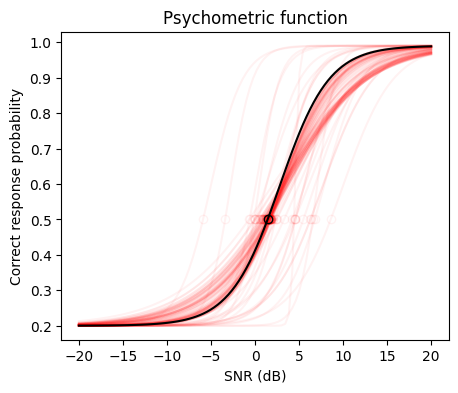

In [378]:
np.set_printoptions(precision=3)
# modelp = np.array([[0.5, 0.5], [0.01, 0.04], [0, 0.1], [-20, -20], [20,20], [0,0], [0.5,0.5]])
modelp = np.array([[0.5], [0.01], [0.2], [-20], [20], [0], [0.5]])

nmodels=modelp.shape[1]
availsnr=np.linspace(-20, 20, 21).T

# print(availsnr)
test=basie_estimator()
# [snr, __, __, __]=v_psycest(-nmodels, modelp=modelp, availsnr=availsnr)
[snr,_,_,_]=test.initialise(1, modelp=modelp, availsnr=availsnr)
truemodel=np.array([[0.5], [0.0], [0.1], [0.01], [0], [1]])
nt = 100
listofresponses = np.array([[1], [0], [0], [0], [0], [0], [1], [1], [1], [1], [1], [0], [1], [1], [0],[1],[0]])
ii=1
fig=plt.figure(figsize=(5,4))

for i in range(nt):
    [response, __] = v_psychofunc('r',truemodel,np.array([snr]));
#     response = np.array([[bool(listofresponses[i])]])
#     response = bool(listofresponses[i])
#     print('snr: ',snr, 'response: ',response, 'model: ', ii)
#     [snr, ii, m, v] = v_psycest(ii, probesnr=snr, response=response, robust=True);
    [snr, ii, m, v] =test.update(ii, probesnr=snr, response=response, robust=False)
#     print(plt.gca().lines)
    test.plot('f', 1)
    if i>0:
        plt.gca().lines[2*i-2].set_alpha(0.05)
        plt.gca().lines[2*i-1].set_alpha(0.05)
#     plt.show()
# print(test.summary()[2])
plt.gca().lines[-1].set_color('k')
plt.gca().lines[-2].set_color('k')

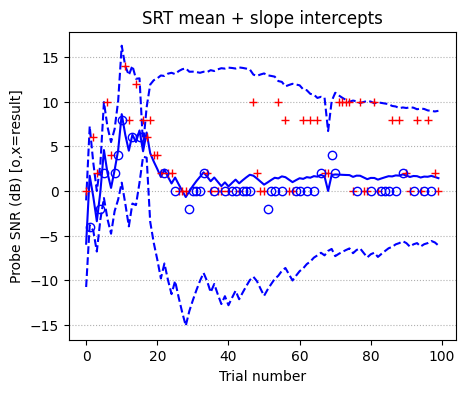

In [385]:
fig=plt.figure(figsize=(5,4))
test.plot('h',1)
# fig=plt.figure(figsize=(5,4))

# test.plot('f',2)
# plt.show()